# Libraries

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import json

%matplotlib inline

# Open Pose

In [2]:
MODE = "MPI"

if MODE is "COCO":
    protoFile = "pose/coco/pose_deploy_linevec.prototxt"
    weightsFile = "pose/coco/pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "pose/mpi/pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

inWidth = 368
inHeight = 368

# Analyizng pose coordinates

In [3]:
img_dir = 'ComparisonMatrixDevelopment'
poses = os.listdir(img_dir)

In [8]:
img_address = []
for pose in poses:
    temp = []
    for img in os.listdir(img_dir + '/' + pose):
        address = img_dir + '/' + pose + '/' + img
        temp.append(address)
    img_address.append(temp)

In [9]:
print(img_address)

[['ComparisonMatrixDevelopment/Goddess/00000104.jpeg'], ['ComparisonMatrixDevelopment/HalfMoon/00000029.jpg'], ['ComparisonMatrixDevelopment/Tree/00000074.jpg'], ['ComparisonMatrixDevelopment/Triangle/00000016.jpg'], ['ComparisonMatrixDevelopment/Warrior2/00000136.jpg']]


In [10]:
print(poses)

['Goddess', 'HalfMoon', 'Tree', 'Triangle', 'Warrior2']


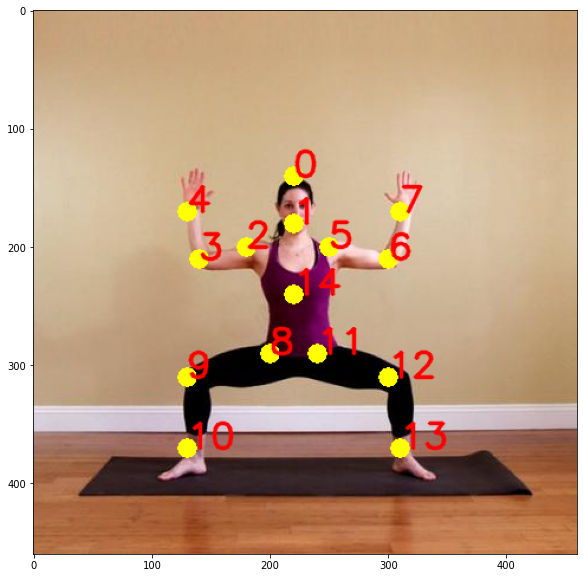

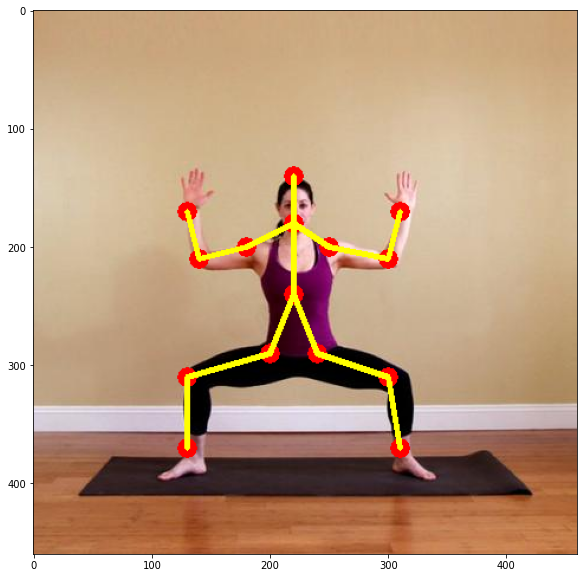

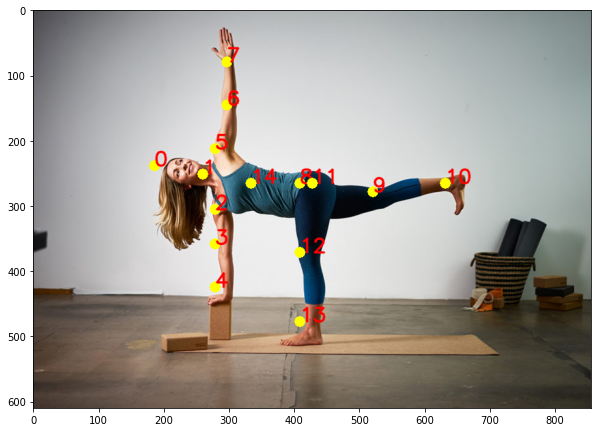

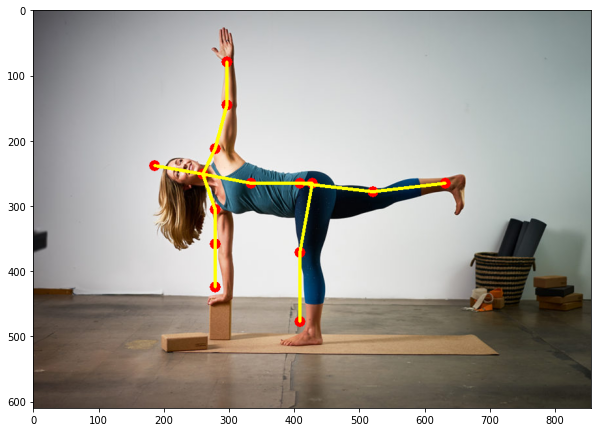

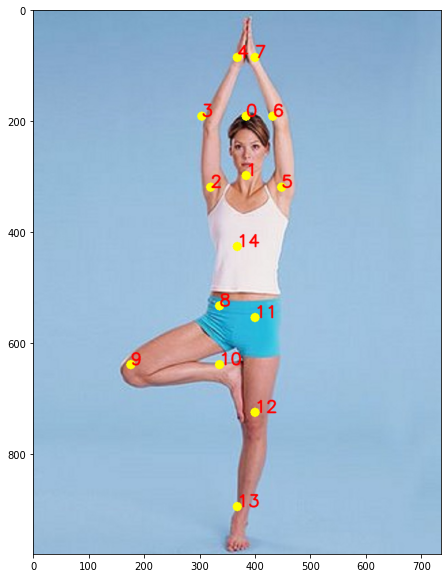

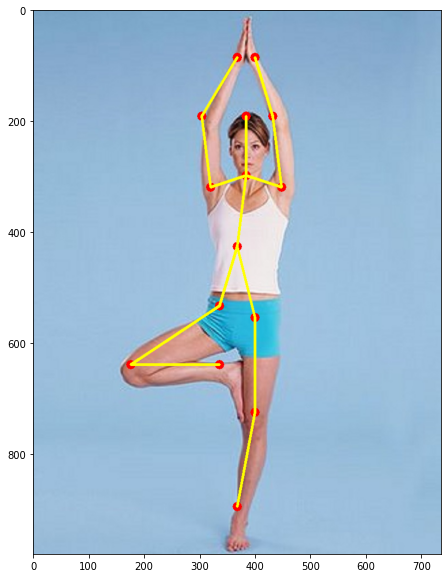

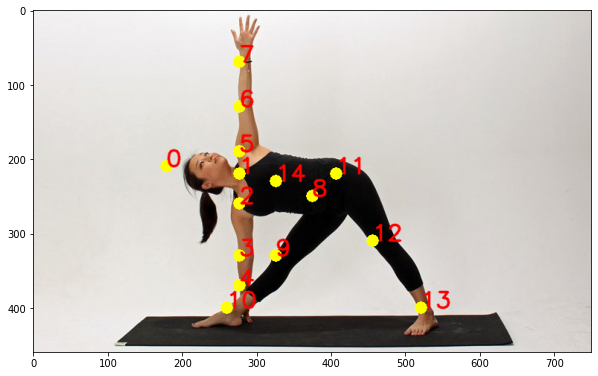

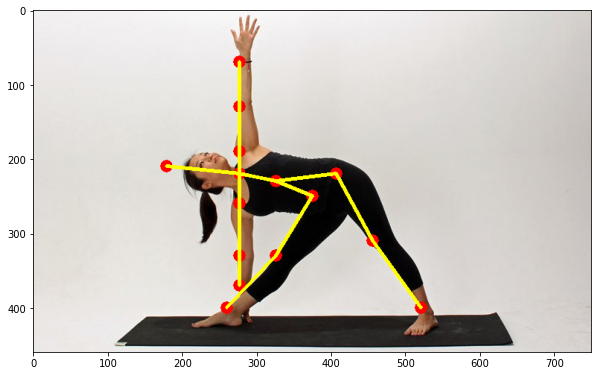

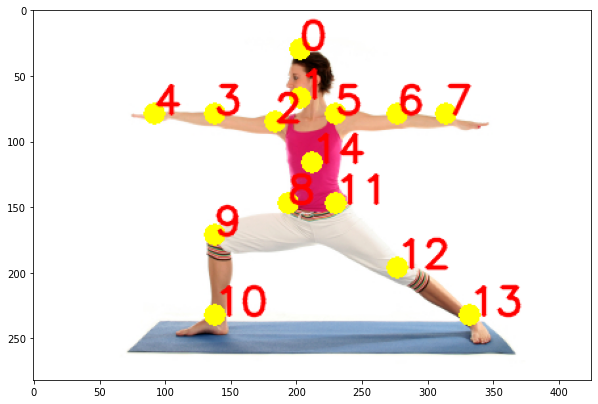

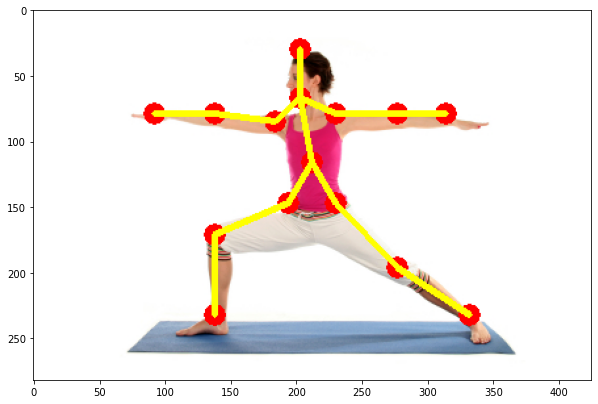

In [11]:
pose_coordinates = []
for pose in img_address:
    coordinates = []
    for img in pose:

        frame = cv2.imread(img)
        frameCopy = np.copy(frame)
        frameWidth = frame.shape[1]
        frameHeight = frame.shape[0]
        threshold = 0.1
        inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                                      (0, 0, 0), swapRB=False, crop=False)

        net.setInput(inpBlob)
        output = net.forward()
        H = output.shape[2]
        W = output.shape[3]
        points = []
        for i in range(nPoints):
            # confidence map of corresponding body's part.
            probMap = output[0, i, :, :]

            # Find global maxima of the probMap.
            minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
            # Scale the point to fit on the original image
            x = (frameWidth * point[0]) / W
            y = (frameHeight * point[1]) / H
            if prob > threshold : 
                cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
                cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
                cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

                # Add the point to the list if the probability is greater than the threshold
                points.append((int(x), int(y)))
            else :
                points.append(None)
        
        coordinates.append(points)
        # Draw Skeleton
        for pair in POSE_PAIRS:
            partA = pair[0]
            partB = pair[1]

            if points[partA] and points[partB]:
                cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3)
        plt.figure(figsize=[10,10])
        plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))
        plt.figure(figsize=[10,10])
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    pose_coordinates.append(coordinates)

In [12]:
print(pose_coordinates[1][0])

[(186, 238), (260, 251), (279, 305), (279, 358), (279, 424), (279, 212), (297, 145), (297, 79), (409, 265), (521, 278), (632, 265), (428, 265), (409, 371), (409, 477), (334, 265)]


#### Relevant joints for goddess : elbow(2-3-4, 5-6-7), knee (8-9-10, 11-12-13),  kneck(0-1-2, 0-1-5),  leg(14-8-9, 14-11-12), back(0-1-14)

In [13]:
open_pose_dict = {
    "elbow-l": [2, 3, 4],
    "elbow-r": [5, 6, 7],
    "knee-l": [8, 9, 10],
    "knee-r": [11, 12, 13],
    "kneck-l": [0, 1, 2],
    "kneck-r": [0, 1, 5],
    "leg-l": [14, 8, 9],
    "leg-r": [14, 11, 12],
    "back": [0, 1, 14]
}

In [14]:
def calculate_angle(indices, coordinates):
    p1 = coordinates[indices[0]]
    p2 = coordinates[indices[1]]
    p3 = coordinates[indices[2]]
    if(p3[0] - p2[0] == 0 and p2[0] - p1[0] == 0):
        return 0
    if(p2[0] - p1[0] == 0):
        m2 = (p3[1] - p2[1])/(p3[0] - p2[0])
        return (90 - math.degrees(math.atan(m2)))
    if(p3[0] - p2[0] == 0):
        m1 = (p2[1] - p1[1])/(p2[0] - p1[0])
        return (90 - math.degrees(math.atan(m1)))
    m1 = (p2[1] - p1[1])/(p2[0] - p1[0])
    m2 = (p3[1] - p2[1])/(p3[0] - p2[0])
    if(m1 * m2 == -1):
        theta = 90
    else:
        tan_theta = (m2-m1)/(1 + m1 * m2)
        theta = math.degrees(math.atan(tan_theta))
    return theta

In [15]:
store_dict = {}
for i, pose in enumerate(poses):
    key = pose
    temp_dict = {}
    temp = pose_coordinates[i][0]
    for k in  open_pose_dict:
        temp_dict[k] = calculate_angle(open_pose_dict[k], temp)        
    store_dict[key] = temp_dict
print(store_dict)

{'Goddess': {'elbow-l': 90, 'elbow-r': -87.27368900609373, 'knee-l': 105.94539590092285, 'knee-r': 62.10272896905237, 'kneck-l': 116.56505117707799, 'kneck-r': 56.309932474020215, 'leg-l': 52.25319461272534, 'leg-r': -49.76364169072618, 'back': 0}, 'HalfMoon': {'elbow-l': 0, 'elbow-r': 164.96218409641776, 'knee-l': -13.30066214553753, 'knee-r': 169.83791680599924, 'kneck-l': 60.65168013073499, 'kneck-r': -73.98941022747586, 'leg-l': 6.620776082314977, 'leg-r': -79.83791680599924, 'back': 0.7493188328838571}, 'Tree': {'elbow-l': 38.24748654569379, 'elbow-r': -9.673355432403495, 'knee-l': 33.52447324857696, 'knee-r': 169.3396517054647, 'kneck-l': 108.16595652922553, 'kneck-r': 71.83404347077447, 'leg-l': 39.82542125282, 'leg-r': 14.036243467926468, 'back': 172.8749836510982}, 'Triangle': {'elbow-l': 0, 'elbow-r': 0, 'knee-l': 11.82784631788973, 'knee-r': -7.271816160531724, 'kneck-l': 84.17365797044422, 'kneck-r': 84.17365797044422, 'leg-l': -80.71600916784341, 'leg-r': 68.47210396943811

In [16]:
for k in store_dict:
    for joint in store_dict[k]:
        if abs(store_dict[k][joint]) > 90:
            store_dict[k][joint] = 180 - abs(store_dict[k][joint])

In [17]:
for k in store_dict:
    print(k, store_dict[k])
    print(" ")

Goddess {'elbow-l': 90, 'elbow-r': -87.27368900609373, 'knee-l': 74.05460409907715, 'knee-r': 62.10272896905237, 'kneck-l': 63.43494882292201, 'kneck-r': 56.309932474020215, 'leg-l': 52.25319461272534, 'leg-r': -49.76364169072618, 'back': 0}
 
HalfMoon {'elbow-l': 0, 'elbow-r': 15.037815903582242, 'knee-l': -13.30066214553753, 'knee-r': 10.162083194000758, 'kneck-l': 60.65168013073499, 'kneck-r': -73.98941022747586, 'leg-l': 6.620776082314977, 'leg-r': -79.83791680599924, 'back': 0.7493188328838571}
 
Tree {'elbow-l': 38.24748654569379, 'elbow-r': -9.673355432403495, 'knee-l': 33.52447324857696, 'knee-r': 10.66034829453531, 'kneck-l': 71.83404347077447, 'kneck-r': 71.83404347077447, 'leg-l': 39.82542125282, 'leg-r': 14.036243467926468, 'back': 7.125016348901795}
 
Triangle {'elbow-l': 0, 'elbow-r': 0, 'knee-l': 11.82784631788973, 'knee-r': -7.271816160531724, 'kneck-l': 84.17365797044422, 'kneck-r': 84.17365797044422, 'leg-l': -80.71600916784341, 'leg-r': 68.47210396943811, 'back': 5.7

In [29]:
os.mkdir('AngleValues')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'AngleValues'

In [18]:
with open("AngleValues/angles.json", "w") as outfile: 
    json.dump(store_dict, outfile)

In [19]:
with open("AngleValues/poseIndices.json", "w") as outfile:
    json.dump(open_pose_dict, outfile)

In [20]:
f = open("AngleValues/angles.json")
angle_dict = json.load(f)

In [21]:
print(type(angle_dict))

<class 'dict'>


In [22]:
f = open("AngleValues/poseIndices.json")
pose_indices_dict = json.load(f)
f.close()